In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet, get_unet_mod
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


#### Models:

| Model | Description | Filename |
|:------|------|--|
|   UNet_Mask  | Unet- Model trained on Handlabeled Mask-Data 'train_df'| unet1024_60epochs.h5 |
|   UNet_Circle  | Unet- Model trained on Handlabeled Mask-Data 'train_df'| - |

In [7]:
imgs = os.listdir(DATA_BASE_PATH+"/03_test/images")
files = {"image_path":DATA_BASE_PATH+"/03_test/images/",
             "name":imgs}
test_field_df = pd.DataFrame.from_dict(files)
test_field_df.sample(3)

image_path                     name
23  ../data/03_test/images/  IMG_20190331_113541.jpg
3   ../data/03_test/images/  IMG_20190331_111251.jpg
32  ../data/03_test/images/  IMG_20190331_113843.jpg

### 1. Unet_Pretrained:

In [6]:
from imports.models.losses import bce_dice_loss, dice_coeff, iou
from keras.models import load_model, model_from_json
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/inceptionv3_unet/new_model.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou':iou,"bce_jaccard_loss":bce_jaccard_loss})

In [112]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

visualize = Visualize(**vis_params)

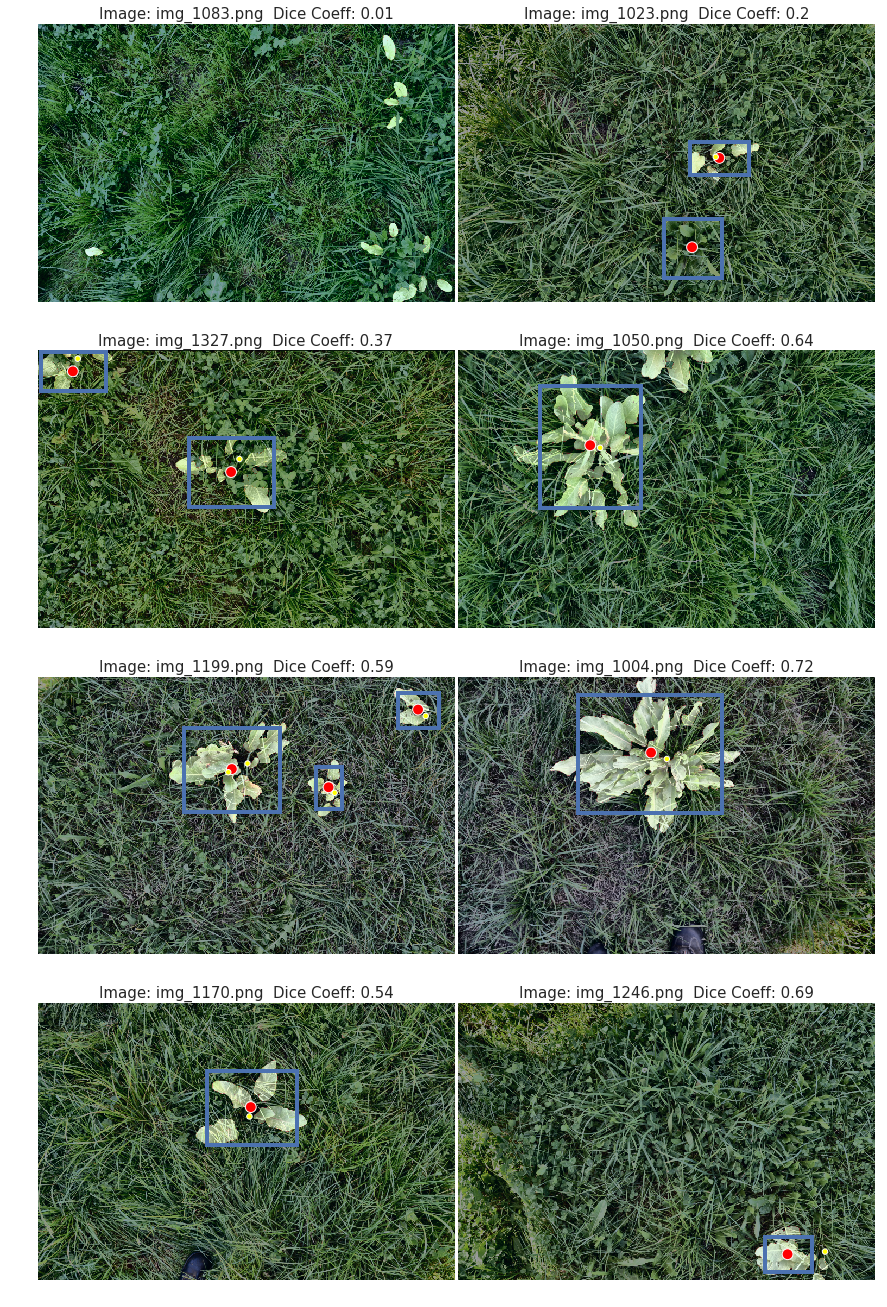

In [137]:
visualize.show_matrix("random","image_prediction_roots")

In [132]:
# Set Tolerance Radius:
tolerance = 60

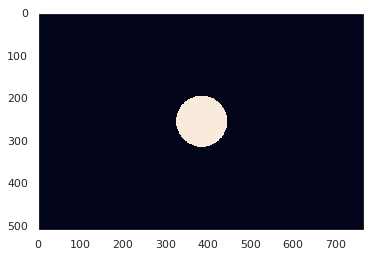

In [133]:
from skimage.draw import circle
img = np.zeros((512, 768), dtype=np.uint8)
rr, cc = circle(512/2, 768/2, tolerance)
img[rr, cc] = 1
imshow(img)

### Accuracy on Validation Set

In [116]:
ev_params = {'df':val_df,
             'input_shape':(512,768,3),
             'pred_layer' : 2,
             'model':model}
ev = Evaluate(**ev_params)

tPs = []
fPs = []
fNs = []
precicions = []
recalls = []
val_log = []
for roots_per_image in range(1,10):
    print("Max roots_per_image: " + str(roots_per_image))
    print("TP\tFP\tFN\tPrecicion\tRecall\tImageName")
    for i,row in val_df.iterrows():
        if len(row["roots"]) <= roots_per_image:
            #print(len(row["roots"]))
            tP, fP, fN, precicion, recall = ev.get_root_precicion(row["name"])
            print("{}\t{}\t{}\t{:1.2f}\t{:1.2f}\t{}".format(tP, fP, fN, precicion, recall, row['name']))
            tPs.append(tP)
            fPs.append(fP)
            fNs.append(fN)
            precicions.append(precicion)
            recalls.append(recall)
    val_log.append((tPs,fPs,fNs,precicions,recalls))
    tPs = []
    fPs = []
    fNs = []
    precicions = []
    recalls = []

Max roots_per_image: 1
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1004.png
1	0	0	1.00	1.00	img_1023.png
1	0	0	1.00	1.00	img_1027.png
1	0	0	1.00	1.00	img_1038.png
1	0	0	1.00	1.00	img_1067.png
1	0	0	1.00	1.00	img_1094.png
1	0	0	1.00	1.00	img_1100.png
1	0	0	1.00	1.00	img_1103.png
0	1	1	0.00	0.00	img_1123.png
1	0	0	1.00	1.00	img_1129.png
1	0	0	1.00	1.00	img_1140.png
1	0	0	1.00	1.00	img_1144.png
1	0	0	1.00	1.00	img_1170.png
1	0	0	1.00	1.00	img_1176.png
1	0	0	1.00	1.00	img_1178.png
1	0	0	1.00	1.00	img_1183.png
1	0	0	1.00	1.00	img_1186.png
1	0	0	1.00	1.00	img_1193.png
1	0	0	1.00	1.00	img_1201.png
1	0	0	1.00	1.00	img_1203.png
1	0	0	1.00	1.00	img_1213.png
1	0	0	1.00	1.00	img_1227.png
0	1	1	0.00	0.00	img_1246.png
1	0	0	1.00	1.00	img_1293.png
1	0	0	1.00	1.00	img_1301.png
1	0	0	1.00	1.00	img_1302.png
0	0	0	0.00	0.00	img_1314.png
1	0	0	1.00	1.00	img_1318.png
1	0	0	1.00	1.00	img_1323.png
1	0	0	1.00	1.00	img_1344.png
1	0	0	1.00	1.00	img_1354.png
1	0	0	1.00	1.00	img_1356.png
1	0	0	1.00	1.

1	0	0	1.00	1.00	img_1027.png
1	0	0	1.00	1.00	img_1038.png
0	1	5	0.00	0.00	img_1049.png
1	0	1	1.00	0.50	img_1050.png
1	1	1	0.50	0.50	img_1051.png
1	0	3	1.00	0.25	img_1060.png
1	0	0	1.00	1.00	img_1067.png
1	1	1	0.50	0.50	img_1072.png
0	0	0	0.00	0.00	img_1083.png
1	0	2	1.00	0.33	img_1084.png
1	0	0	1.00	1.00	img_1085.png
1	0	0	1.00	1.00	img_1094.png
1	0	0	1.00	1.00	img_1100.png
1	0	0	1.00	1.00	img_1103.png
1	0	1	1.00	0.50	img_1108.png
2	0	1	1.00	0.67	img_1111.png
2	0	0	1.00	1.00	img_1113.png
4	0	1	1.00	0.80	img_1114.png
2	0	0	1.00	1.00	img_1115.png
1	0	3	1.00	0.25	img_1120.png
3	0	1	1.00	0.75	img_1121.png
0	1	1	0.00	0.00	img_1123.png
1	0	0	1.00	1.00	img_1129.png
1	0	0	1.00	1.00	img_1140.png
1	0	0	1.00	1.00	img_1144.png
2	0	1	1.00	0.67	img_1152.png
2	0	1	1.00	0.67	img_1156.png
2	0	0	1.00	1.00	img_1157.png
1	0	0	1.00	1.00	img_1163.png
1	0	0	1.00	1.00	img_1170.png
1	0	0	1.00	1.00	img_1176.png
1	0	0	1.00	1.00	img_1178.png
1	0	2	1.00	0.33	img_1181.png
1	0	0	1.00	1.00	img_1183.png
1	0	1	1.00	0.5

1	0	1	1.00	0.50	img_1435.png
1	0	0	1.00	1.00	img_1436.png
0	0	0	0.00	0.00	img_1440.png
2	0	0	1.00	1.00	img_1452.png
1	0	0	1.00	1.00	img_1463.png
1	0	3	1.00	0.25	img_1467.png
1	0	0	1.00	1.00	img_1470.png
2	0	1	1.00	0.67	img_1473.png
1	0	1	1.00	0.50	img_1487.png
3	0	2	1.00	0.60	img_1489.png
3	0	2	1.00	0.60	img_1497.png
1	0	0	1.00	1.00	img_1506.png
Max roots_per_image: 8
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1004.png
1	1	3	0.50	0.25	img_1018.png
1	0	0	1.00	1.00	img_1023.png
1	0	0	1.00	1.00	img_1027.png
1	0	0	1.00	1.00	img_1038.png
0	1	5	0.00	0.00	img_1049.png
1	0	1	1.00	0.50	img_1050.png
1	1	1	0.50	0.50	img_1051.png
1	0	3	1.00	0.25	img_1060.png
1	0	0	1.00	1.00	img_1067.png
1	1	1	0.50	0.50	img_1072.png
0	0	0	0.00	0.00	img_1083.png
1	0	2	1.00	0.33	img_1084.png
1	0	0	1.00	1.00	img_1085.png
1	0	0	1.00	1.00	img_1094.png
1	0	0	1.00	1.00	img_1100.png
1	0	0	1.00	1.00	img_1103.png
1	0	1	1.00	0.50	img_1108.png
2	0	1	1.00	0.67	img_1111.png
2	0	0	1.00	1.00	img_1113.png
4	0	1	1.00	0.

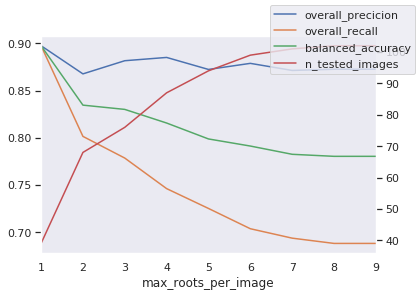

In [126]:
results = {"max_roots_per_image":range(1,len(val_log)+1),
           "true_positive_rate":"pass",
             "overall_precicion":[sum(p[3])/len(p[3]) for p in val_log],
             "overall_recall":[sum(p[4])/len(p[4]) for p in val_log],
             "balanced_accuracy": list((np.asarray([sum(p[3])/len(p[3]) for p in val_log]) + np.asarray([sum(p[4])/len(p[4]) for p in val_log]))/2),
            "n_tested_images":[len(p[0]) for p in val_log]}
test_field_df = pd.DataFrame.from_dict(results)
test_field_df

sns.set(style="dark")
ax = test_field_df[['max_roots_per_image','overall_precicion','overall_recall','balanced_accuracy']].plot(x='max_roots_per_image',legend=False)
ax2 = ax.twinx()
test_field_df[['max_roots_per_image','n_tested_images']].plot(x='max_roots_per_image',y='n_tested_images', ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

### Accuracy on Test Set:

In [66]:
ev_params = {'df':test_df,
             'input_shape':(512,768,3),
             'pred_layer' : 2,
             'model':model}
ev = Evaluate(**ev_params)

tPs = []
fPs = []
fNs = []
precicions = []
recalls = []
test_log = []
for roots_per_image in range(1,7):
    print("Max roots_per_image: " + str(roots_per_image))
    print("TP\tFP\tFN\tPrecicion\tRecall\tImageName")
    for i,row in test_df.iterrows():
        if len(row["roots"]) <= roots_per_image:
            #print(len(row["roots"]))
            tP, fP, fN, precicion, recall = ev.get_root_precicion(row["name"],tolerance=tolerance)
            print("{}\t{}\t{}\t{:1.2f}\t{:1.2f}\t{}".format(tP, fP, fN, precicion, recall, row['name']))
            tPs.append(tP)
            fPs.append(fP)
            fNs.append(fN)
            precicions.append(precicion)
            recalls.append(recall)
    test_log.append((tPs,fPs,fNs,precicions,recalls))
    tPs = []
    fPs = []
    fNs = []
    precicions = []
    recalls = []

Max roots_per_image: 1
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1030.png
1	0	0	1.00	1.00	img_1032.png
1	0	0	1.00	1.00	img_1044.png
1	0	0	1.00	1.00	img_1143.png
1	0	0	1.00	1.00	img_1205.png
1	0	0	1.00	1.00	img_1217.png
1	0	0	1.00	1.00	img_1219.png
1	0	0	1.00	1.00	img_1232.png
1	0	0	1.00	1.00	img_1277.png
1	0	0	1.00	1.00	img_1304.png
1	0	0	1.00	1.00	img_1361.png
1	0	0	1.00	1.00	img_1390.png
1	0	0	1.00	1.00	img_1392.png
1	0	0	1.00	1.00	img_1393.png
1	0	0	1.00	1.00	img_1432.png
1	0	0	1.00	1.00	img_1434.png
1	0	0	1.00	1.00	img_1466.png
1	0	0	1.00	1.00	img_1498.png
Max roots_per_image: 2
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1030.png
1	0	0	1.00	1.00	img_1032.png
1	0	0	1.00	1.00	img_1044.png
2	0	0	1.00	1.00	img_1062.png
1	0	0	1.00	1.00	img_1143.png
1	1	1	0.50	0.50	img_1154.png
1	0	1	1.00	0.50	img_1164.png
1	0	0	1.00	1.00	img_1205.png
1	0	0	1.00	1.00	img_1217.png
1	0	0	1.00	1.00	img_1219.png
1	0	0	1.00	1.00	img_1232.png
2	0	0	1.00	1.00	img_1262.png
1	0	0	1.00	1

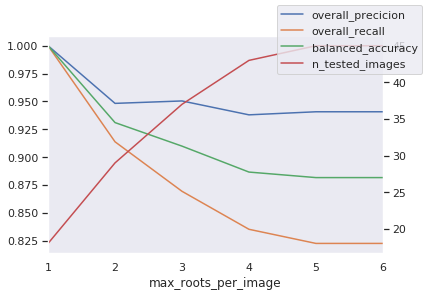

In [136]:
results = {"max_roots_per_image":range(1,len(test_log)+1),
           "true_positive_rate":"pass",
             "overall_precicion":[sum(p[3])/len(p[3]) for p in test_log],
             "overall_recall":[sum(p[4])/len(p[4]) for p in test_log],
             "balanced_accuracy": list((np.asarray([sum(p[3])/len(p[3]) for p in test_log]) + np.asarray([sum(p[4])/len(p[4]) for p in test_log]))/2),
            "n_tested_images":[len(p[0]) for p in test_log]}
test_field_df = pd.DataFrame.from_dict(results)
test_field_df

sns.set(style="dark")
ax = test_field_df[['max_roots_per_image','overall_precicion','overall_recall','balanced_accuracy']].plot(x='max_roots_per_image',legend=False)
ax2 = ax.twinx()
test_field_df[['max_roots_per_image','n_tested_images']].plot(x='max_roots_per_image',y='n_tested_images', ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

### Dice Coeff on Validation Set:

In [18]:
ev_params = {'df':val_df,
             'input_shape':(512,768,3),
             'pred_layer' : 2,
             'model':model}
ev = Evaluate(**ev_params)
unet_mask_dice_min, unet_mask_dice_max, unet_mask_dice_avg = ev.get_dice_coeff(mode='simple')

Average prediction time: 1.01 s


In [19]:
print("Average Dice Coefficient: %f" % unet_mask_dice_avg)
print("Min Dice Coefficient: %f" % unet_mask_dice_min)
print("Max Dice Coefficient: %f" % unet_mask_dice_max)

Average Dice Coefficient: 0.797958
Min Dice Coefficient: 0.002473
Max Dice Coefficient: 0.937779


#### Tests

In [110]:
img = visualize.get_mask("img_1253")
test = np.zeros((*img.shape,3))
test[:,:,0] = img
test[:,:,1] = img
test[:,:,2] = img

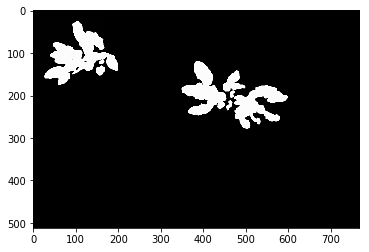

In [113]:
import cv2
shift = cv2.pyrMeanShiftFiltering((test*255).astype("uint8"),80,80)
imshow(shift)

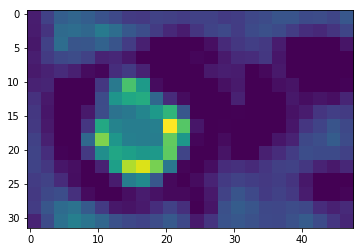

In [113]:
last_conv_layer = model.get_layer("decoder_stage0_upsample")
grads = K.gradients(model.output,last_conv_layer.output)[0]
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img.reshape(1,*SHAPE,3)])

for i in range(2048):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
imshow(heatmap)

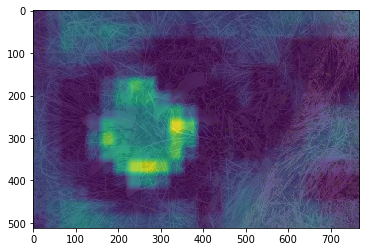

In [109]:
import cv2
heatmap = cv2.resize(heatmap,(768,512))
imshow(img)
imshow(heatmap,alpha=0.8)

In [43]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=test.output)
pred = activation_model.predict(img.reshape(1,*SHAPE,3))


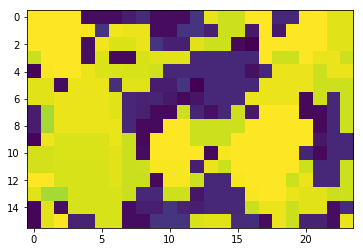

In [44]:
new = np.argmax(pred,axis=3)
new.shape
imshow(new.reshape(16,24))